<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/DepthPro_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces inference with [DepthPro](https://huggingface.co/docs/transformers/main/en/model_doc/depthpro) model for depth estimation intorduced by Apple.

- DepthPro is zero-shot monocular **metric** depth estimation network.
- The whole network operates at a fixed resolution of 1536×1536 to achieve super sharp depth estimation while avoiding OOM errors for larger images.
- The network comes with an optional focal length estimation head. A small convolutional head, which ingests frozen features from the depth estimation network and task-specific features from a separate ViT image encoder to predict the horizontal angular field-of-view (FoV).

Abstract:  

*We present a foundation model for zero-shot metric monocular depth estimation. Our model, Depth Pro, synthesizes high-resolution depth maps with unparalleled sharpness and high-frequency details. The predictions are metric, with absolute scale, without relying on the availability of metadata such as camera intrinsics. And the model is fast, producing a 2.25-megapixel depth map in 0.3 seconds on a standard GPU. These characteristics are enabled by a number of technical contributions, including an efficient multi-scale vision transformer for dense prediction, a training protocol that combines real and synthetic datasets to achieve high metric accuracy alongside fine boundary tracing, dedicated evaluation metrics for boundary accuracy in estimated depth maps, and state-of-the-art focal length estimation from a single image. Extensive experiments analyze specific design choices and demonstrate that Depth Pro outperforms prior work along multiple dimensions.*

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/depth_pro_architecture.png)
![](https://github.com/apple/ml-depth-pro/blob/main/data/depth-pro-teaser.jpg?raw=true)



 - Paper: https://arxiv.org/abs/2410.02073
 - Project Page: https://promptda.github.io/

In this notebook we will cover the following steps:  

 - Loading an image
 - Loading pretrained model and image_processor from [HuggingFace Hub](https://huggingface.co/models?other=prompt_depth_anything)
 - Inference WITHOUT FoV (field of view)
 - Inference WITH FoV
 - Visualization of predicted depth maps

But first, let make sure we have the lates `transformers` installed:

In [1]:
!pip install -U -q git+https://github.com/geetu040/transformers@depth-pro

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
import torch
import requests
import numpy as np

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16

print(f"Device: {device}")

Device: cuda


### Load data

Image size: [2268, 3024]


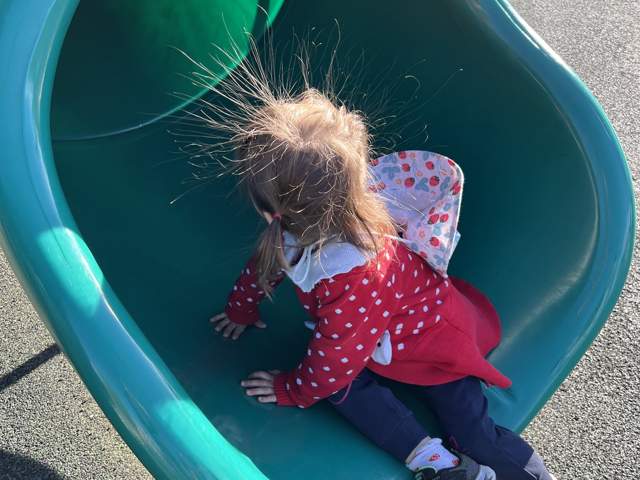

In [5]:
# image for depth estimation
url = "https://github.com/apple/ml-depth-pro/blob/main/data/example.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

print("Image size:", [image.height, image.width])
image.resize((640, 480)) # resize for visualization

### Load model and image processor from the Hugging Face Hub

Image processor is an object responsible for image normalization/resizing and results posprocessing, such as resizing depth map back to the image scale.

In [12]:
checkpoint = "geetu040/DepthPro"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(
    checkpoint, device_map=device, torch_dtype=dtype
)

# In case you want to save some memory
# Also ther would be a message re unused weight, it's normal since we do not
# initilize part of the model
model_no_fov = AutoModelForDepthEstimation.from_pretrained(
    checkpoint, device_map=device, torch_dtype=dtype, use_fov_model=False
)

Some weights of the model checkpoint at geetu040/DepthPro were not used when initializing DepthProForDepthEstimation: ['fov_model.encoder.embeddings.cls_token', 'fov_model.encoder.embeddings.patch_embeddings.projection.bias', 'fov_model.encoder.embeddings.patch_embeddings.projection.weight', 'fov_model.encoder.embeddings.position_embeddings', 'fov_model.encoder.encoder.layer.0.attention.attention.key.bias', 'fov_model.encoder.encoder.layer.0.attention.attention.key.weight', 'fov_model.encoder.encoder.layer.0.attention.attention.query.bias', 'fov_model.encoder.encoder.layer.0.attention.attention.query.weight', 'fov_model.encoder.encoder.layer.0.attention.attention.value.bias', 'fov_model.encoder.encoder.layer.0.attention.attention.value.weight', 'fov_model.encoder.encoder.layer.0.attention.output.dense.bias', 'fov_model.encoder.encoder.layer.0.attention.output.dense.weight', 'fov_model.encoder.encoder.layer.0.layer_scale1.lambda1', 'fov_model.encoder.encoder.layer.0.layer_scale2.lambda1

### Inference with FoV

In [27]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model(**inputs)

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_output

Preprocessed inputs: dict_keys(['pixel_values'])


[{'predicted_depth': tensor([[0.9614, 0.9341, 0.8853,  ..., 3.0156, 2.9746, 2.9551],
          [0.9219, 0.9004, 0.8613,  ..., 3.0176, 3.0156, 3.0137],
          [0.8818, 0.8662, 0.8374,  ..., 3.0293, 3.0508, 3.0605],
          ...,
          [1.2305, 1.2285, 1.2246,  ..., 1.2715, 1.2832, 1.2891],
          [1.2246, 1.2256, 1.2285,  ..., 1.2686, 1.2812, 1.2891],
          [1.2178, 1.2236, 1.2354,  ..., 1.2666, 1.2764, 1.2822]],
         device='cuda:0', dtype=torch.float16),
  'fov': tensor(3364., device='cuda:0', dtype=torch.float16)}]

In [28]:
predicted_depth = post_processed_output[0]["predicted_depth"]

min = predicted_depth.min().item()
max = predicted_depth.max().item()

print("Predicted depth shape:", predicted_depth.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([2268, 3024])
Predicted depth range: 0.61..3.08 (meters)


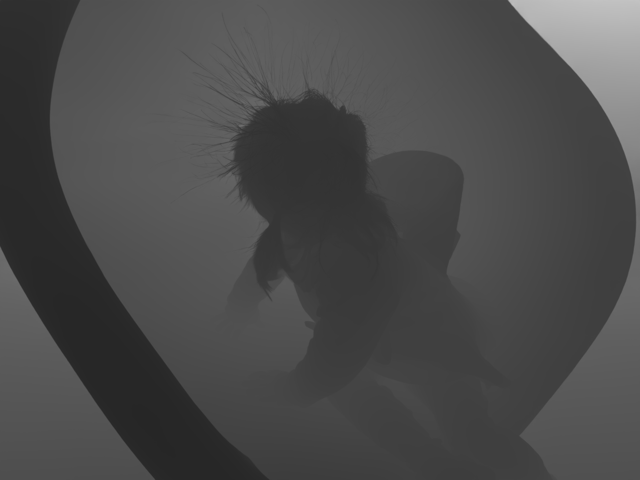

In [30]:
# Visualize the prediction
# Let's normalize it with respect to 4 meters depth (beacuse maximum depth is 3.08)
# JUST for visualization and comparison with NO FoV model
max_depth = 4
normalized_depth = predicted_depth.cpu().numpy() / max_depth
normalized_depth = Image.fromarray((normalized_depth * 255).astype("uint8"))

normalized_depth.resize([640, 480])

### Inference without FoV

In [31]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model_no_fov(**inputs)

# interpolate to original size
post_processed_outputno_fov = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_outputno_fov

Preprocessed inputs: dict_keys(['pixel_values'])


[{'predicted_depth': tensor([[0.8643, 0.8394, 0.7954,  ..., 2.7109, 2.6738, 2.6562],
          [0.8286, 0.8091, 0.7739,  ..., 2.7129, 2.7109, 2.7090],
          [0.7925, 0.7788, 0.7524,  ..., 2.7207, 2.7422, 2.7520],
          ...,
          [1.1055, 1.1045, 1.1006,  ..., 1.1426, 1.1533, 1.1592],
          [1.1006, 1.1016, 1.1045,  ..., 1.1406, 1.1523, 1.1582],
          [1.0947, 1.1006, 1.1104,  ..., 1.1387, 1.1484, 1.1523]],
         device='cuda:0', dtype=torch.float16),
  'fov': None}]

In [32]:
predicted_depth_no_fov = post_processed_outputno_fov[0]["predicted_depth"]

min = predicted_depth_no_fov.min().item()
max = predicted_depth_no_fov.max().item()

print("Predicted depth shape:", predicted_depth_no_fov.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([2268, 3024])
Predicted depth range: 0.55..2.77 (meters)


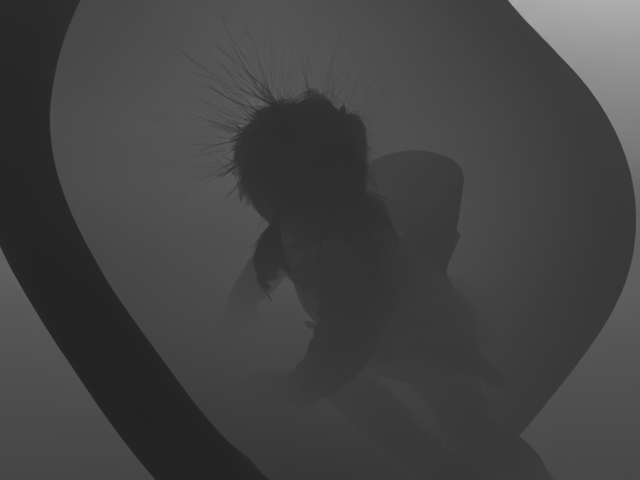

In [33]:
# Visualize the prediction
# Also romalize to max_depth=4 to make comparison FoV / no FoV models
normalized_depth_no_fov = predicted_depth_no_fov.cpu().numpy() / max_depth
normalized_depth_no_fov = Image.fromarray((normalized_depth_no_fov * 255).astype("uint8"))

normalized_depth_no_fov.resize([640, 480])

### Visualize all together

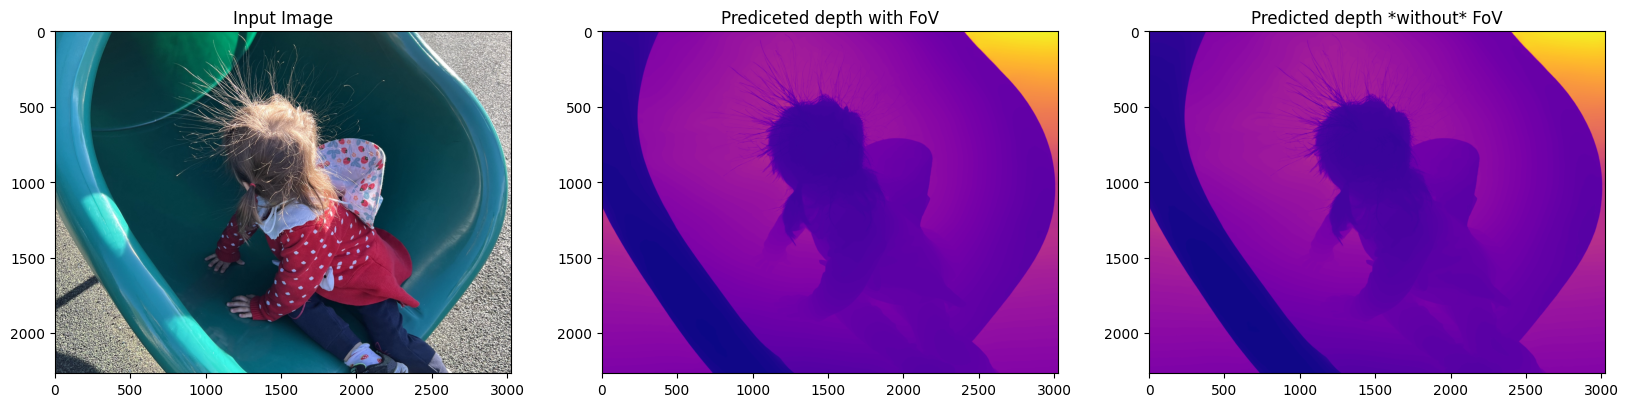

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Prediceted depth with FoV")
plt.imshow(normalized_depth, cmap='plasma')

plt.subplot(1, 3, 3)
plt.title("Predicted depth *without* FoV")
plt.imshow(normalized_depth_no_fov, cmap='plasma')

plt.show()